<a href="https://colab.research.google.com/github/thyeaditungson29/mystudy_ADL2022/blob/main/HW_ADL_WassersteinGAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **improve image generation using Wasserstein GAN**


*   By: Renu Khandelwal
*   source: https://medium.com/mlearning-ai/how-to-improve-image-generation-using-wasserstein-gan-1297f449ca75

*   Dataset: MNIST


focus: Improve the MNIST image generation by implementing Wasserstein GAN(WGAN) with Weight Clipping and Gradient Penalty using PyTorch.

*Homework understanding Wasserstein GAN (WGAN)*


**Algoritma**

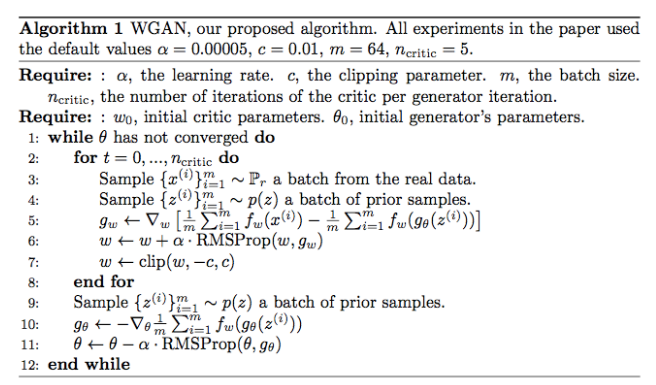

In [1]:
#Install pytorch dan pytorch lightning
! pip install --quiet "torchvision" "pytorch-lightning>=1.4" "torchmetrics>=0.6" "ipython[notebook]" "torch>=1.6, <1.9"

     |████████████████████████████████| 585 kB 5.1 MB/s 
     |████████████████████████████████| 419 kB 49.5 MB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 140 kB 67.1 MB/s 
     |████████████████████████████████| 596 kB 39.2 MB/s 
     |████████████████████████████████| 1.1 MB 51.9 MB/s 
     |████████████████████████████████| 21.0 MB 104.3 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
     |████████████████████████████████| 23.3 MB 78.1 MB/s 
     |████████████████████████████████| 23.3 MB 3.3 MB/s 
     |████████████████████████████████| 22.1 MB 64.3 MB/s 
     |████████████████████████████████| 22.1 MB 99.1 MB/s 
     |████████████████████████████████| 17.4 MB 689 kB/s 
     |████████████████████████████████| 271 kB 66.1 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 67.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account

**Import Library yang digunakan**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

**Load MNIST Dataset**

In [3]:
# Transfor the images to tensors and normalize them
my_transform = transforms.Compose([transforms.Resize(28),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, ), std=(0.5,))])
# Load MNIST dataset as tensors
batch_size=128
dataloader = DataLoader(
   datasets.MNIST('.', download=True, transform=my_transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Setting Perangkat**

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

**Generate Vektor Noise**

In [6]:
def get_noise(n_samples, noise_dim, device='GPU'):
    '''
    Generate noise vectors from the random normal distribution with dimensions (n_samples, noise_dim),
    where
        n_samples: the number of samples to generate based on  batch_size
        noise_dim: the dimension of the noise vector
        device: device type can be cuda or cpu
    '''
    
    return  torch.randn(n_samples,noise_dim, 1,1,device=device)

**Fungsi Generator**

In [7]:
class Generator(nn.Module):
    def __init__(self, no_of_channels=1, noise_dim=100, gen_dim=32):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(noise_dim, gen_dim*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(gen_dim*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(gen_dim*4, gen_dim*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(gen_dim*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(gen_dim*2, gen_dim, 4, 2, 1, bias=False),
          nn.BatchNorm2d(gen_dim),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(gen_dim, no_of_channels, 4, 2, 1, bias=False),
          nn.Tanh()
      )
  
    def forward(self, input):
      output = self.network(input)
      return output

**Fungsi Diskriminator**

In [8]:
class Discriminator(nn.Module):
    def __init__(self, no_of_channels=1, disc_dim=32):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
                
                nn.Conv2d(no_of_channels, disc_dim, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(disc_dim, disc_dim * 2, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(disc_dim * 2, affine=True),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(disc_dim * 2, disc_dim * 4, 3, 2, 1, bias=False),
                nn.InstanceNorm2d(disc_dim * 4, affine=True),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(disc_dim * 4, 1, 4, 1, 0, bias=False),
                
            )
    def forward(self, input):
        output = self.network(input)
        #return output.view(-1, 1).squeeze(1)
        return output

**Membuat Instans Generator dan Kritis**

In [9]:
gen = Generator().to(device)
critic =Discriminator().to(device)

*Inisialisasi bobot untuk* `Conv2d`, `ConvTranspose2d` *dan* `BatchNorm2d` *ke distribusi normal dengan rata-rata 0 dan standar deviasi 0,02*

In [10]:
# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(m.bias, val=0)
gen = gen.apply(weights_init)
critic = critic.apply(weights_init)

**Mendefinisikan Loss dan Optimizer untuk Generator dan Kritis**

In [11]:
lr = 5e-5
criterion = nn.BCEWithLogitsLoss()
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lr)
critic_opt = torch.optim.RMSprop(critic.parameters(), lr=lr)

**Melatih WGAN dengan Weight Clipping**

*Tetapkan parameter WEIGHT_CLIP untuk memastikan bahwa parameter kritikus tidak melebihi nilai antara -0,01 hingga 0,01.*

*Juga, melatih kritikus lebih dari generator menggunakan parameter* `CRITIC_ITERATIONS` *memastikan bahwa kritikus tidak jenuh untuk mencegah mode runtuh.*

In [15]:
from IPython.display import Image, display
n_epochs = 5
cur_step = 0
display_step = 500
z_dim=100
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real_image, _ in tqdm(dataloader):
        cur_batch_size = real_image.shape[0]
        
        real_image = real_image.to(device)
        #Train Critic more than the generator for reliable gradients
        for _ in range(CRITIC_ITERATIONS):
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            critic_fake_pred = critic(fake).reshape(-1)
            critic_real_pred = critic(real_image).reshape(-1)
            #claculate the critic loss
            critic_loss = -(torch.mean(critic_real_pred) -torch.mean(critic_fake_pred))
            critic.zero_grad()
            #To make a backward pass and retain the intermediary results
            critic_loss.backward(retain_graph=True)
            # Update optimizer
            critic_opt.step()
            
            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
        # Train Generator: min E[critic(fake)]
        gen_fake= critic(fake).reshape(-1)
        gen_loss = torch.mean(gen_fake)
        gen.zero_grad()
        gen_loss.backward()
        # Update optimizer
        gen_opt.step()
## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {gen_loss}, critic loss: {critic_loss}")
            display(Image(fake))
            display(Image(real_image))
            gen_loss = 0
            critic_loss = 0
        cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: -0.19161923229694366, critic loss: -0.37024128437042236


/usr/local/lib/python3.7/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'torch.Tensor'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>

<IPython.core.display.Image object>

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: -0.19257265329360962, critic loss: -0.3713130056858063


<IPython.core.display.Image object>

<IPython.core.display.Image object>

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: -0.19313699007034302, critic loss: -0.3724420666694641


<IPython.core.display.Image object>

<IPython.core.display.Image object>

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: -0.19314999878406525, critic loss: -0.3726269602775574


<IPython.core.display.Image object>

<IPython.core.display.Image object>